# Projeto Final - Machine Learning
## Rafael Torres Souza

Aplicativos de mensageria já há certo tempo se mostram como plataforma onde a proliferação de _spams_ é algo comum, e em especial, mensagens de mídia (imagens, vídeos, áudios, etc.) circulam como _spams_. Esse trabalho se propõe à avaliar o uso de uma rede convolucional para predizer se determinada imagem é ou não ou _spams_, utilizando _data augmentation_.

Os principais resultados estão presentes na documentação também enviada; este _notebook_ está sendo enviado como uma amostra de como obter os mesmos resultados presentes na documentação, mas é um tanto quanto inviável exibir as mesmas informações aqui, por conta do tempo necessário para execução.

### Dados utilizados
Os dados utilizados para construção dessa rede se dividem em: Exemplos de imagens consideradas como _spam_ (que representam a classe que se deseja reconhecer), e imagens que não sejam consideradas como _spam_.
Para o primeiro grupo, a coleta foi feita de forma manual; imagens dessa natureza foram armazenadas em aplicativos de mensageria para integrar o _dataset_ do trabalho. Já para o segundo grupo, foram utilizadas imagens do _dataset_ público _Open Images_:<br><br>

`Open Images is a dataset of ~9M images annotated with image-level labels, object bounding boxes, object segmentation masks, and visual relationships. It contains a total of 16M bounding boxes for 600 object classes on 1.9M images, making it the largest existing dataset with object location annotations.`
<br><br>
Por limitação das imagens encontradas para o primeiro grupo, o _dataset_ do trabalho é composto por 530 imagens não-consideradas _spam_, e 530 imagens consideradas _spam_.
<br><br>

O _dataset_ construido encontra-se no repositório abaixo; para utilizar, basta clonar:

In [1]:
! git clone https://github.com/rafaatsouza/ml_project_dataset.git

Cloning into 'ml_project_dataset'...
remote: Enumerating objects: 5834, done.
remote: Counting objects: 100% (5834/5834), done.
remote: Compressing objects: 100% (5832/5832), done.
remote: Total 5834 (delta 0), reused 5831 (delta 0), pack-reused 0
Receiving objects: 100% (5834/5834), 557.67 MiB | 37.71 MiB/s, done.
Checking out files: 100% (5831/5831), done.


### Implementação
Foi escolhida uma rede neural convolucional para esse trabalho, pela necessidade de convolucionar os dados de entrada, que possuem uma dimensionalidade grande e ao final receber um dado único - a classe de uma determinada imagem (no caso, _spam_ ou não). Uma rede neural recorrente não se aplicaria, pela não necessidade de manter um contexto temporal na rede.

#### Algoritmos Utilizados
Pela pequena quantidade de dados disponíveis para o trabalho, foi utilizado _Data Augmentation_ à partir do _dataset_ construído. Conjunto de treino contou com algumas variações possíveis dessa técnica além do redimensionamento, variação que também foi utilizada nos conjuntos de teste e validação, para garantir que todos os dados estivessem com o tamanho padronizado.
<br><br>
O primeiro passo para iniciar os experimentos é realizar os _imports_ e declarar as constantes:

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import sys
import os

from keras.layers import Convolution2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from sklearn.utils import shuffle
from matplotlib import gridspec
from sklearn import metrics
from PIL import Image

SPAM_FOLDER = 'ml_project_dataset/spam/'
NOT_SPAM_FOLDER = 'ml_project_dataset/not_spam/'
BATCH_SIZE = 32
FOLDS_COUNT = 5
EPOCHS = [10,20,30,40,50,60,70,80,90]
NOT_SPAM_PROPORTION = [1,2,3,4]

tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


Tendo feito isso, iremos declarar as classes utilizados. Primeiro, a classe _DataSet_; Ela é responsável por organizar as imagens vindas do repositório em uma estrutura de dados já agrupados em _folds_ (para implementação de _K-Fold Cross Validation_) tanto para implementações que usem _Data Augmentation_ quanto para implementações que não usem. 
<br>
Valores específicos para a utilização de _Data Augmentation_ como _shear range_ e _zoom range_ estão fixos nesta classe, mas foram obtidos após vários testes durante o projeto, mas de forma "improvisada".

In [0]:
class DataSet:
    def __init__(self, spamFolderPath, notSpamFolderPath, notSpamProportion):
        self.df = shuffle(self.GetDataFrame(spamFolderPath, notSpamFolderPath, notSpamProportion))
        
    def GetDataFrame(self, spamFolderPath, notSpamFolderPath, notSpamProportion):
        data = []
        spamCount = 0
        notSpamCount = 0
        for filename in os.listdir(spamFolderPath):
            data.append(['{}{}'.format(spamFolderPath,filename), '1'])
            spamCount += 1
        for filename in os.listdir(notSpamFolderPath):
            if(notSpamCount >= (spamCount * notSpamProportion)):
                break
            data.append(['{}{}'.format(notSpamFolderPath,filename), '0'])
            notSpamCount += 1
        print('Dataframe filled with {} images labelled as "not_spam" and {} images labelled "spam"'.format(notSpamCount, spamCount))
        return pd.DataFrame(data, columns = ['id', 'label'])

    def GetEqualDataFrameFolds(self, df, foldsCount):
        foldSize = round(df.shape[0] / foldsCount)
        folds = [df[x:x+foldSize] for x in range(0, df.shape[0], foldSize)]
        if(len(folds) > foldsCount):
            lastPart = folds.pop()
            folds[-1] = folds[-1].append(lastPart)
            del lastPart
        del foldSize
        return folds

    def GetFolds(self, foldsCount):
        folds = self.GetEqualDataFrameFolds(self.df, foldsCount)

        kfolds = []
        for i in range(0, foldsCount):
            kfolds.append({ 'trainData': [], 'trainLabel': [], 'validationData': [], 'validationLabel': [] })

            trainDf = None
            validationDf = folds[i]

            for j in [x for x in range(0, foldsCount) if x!=i]:
                if(trainDf is None):
                    trainDf = folds[j]
                else:
                    trainDf = trainDf.append(folds[j])

            for index, row in trainDf.head().iterrows():
                kfolds[i]['trainData'].append(self.GetImageNumpyArray(row['id']))
                kfolds[i]['trainLabel'].append(int(row['label']))

            kfolds[i]['trainData'] = (np.array(kfolds[i]['trainData'])).astype('float32')/255
            kfolds[i]['trainLabel'] = np.array(kfolds[i]['trainLabel'])

            for index, row in validationDf.head().iterrows():
                kfolds[i]['validationData'].append(self.GetImageNumpyArray(row['id']))
                kfolds[i]['validationLabel'].append(int(row['label']))

            kfolds[i]['validationData'] = (np.array(kfolds[i]['validationData'])).astype('float32')/255
            kfolds[i]['validationLabel'] = np.array(kfolds[i]['validationLabel'])

            del trainDf
            del validationDf

        del folds

        return kfolds

    def GetImageNumpyArray(self, imageFileName):
        imgArray = cv2.imread(imageFileName)
        imageFromArray = Image.fromarray(imgArray, 'RGB')
        resizedImage = imageFromArray.resize((64, 64))
        del imgArray
        del imageFromArray
        return np.array(resizedImage)

    def GetAugFolds(self, batchSize, foldsCount):
        folds = self.GetEqualDataFrameFolds(self.df, foldsCount)

        train_datagen = ImageDataGenerator(rescale=1./255, 
                        shear_range=0.2, 
                        zoom_range=0.2, 
                        fill_mode='reflect',
                        horizontal_flip=True)
        
        test_datagen = ImageDataGenerator(rescale=1./255)
        validation_datagen = ImageDataGenerator(rescale=1./255)

        kfolds = []
        for i in range(0, foldsCount):
            kfolds.append({ 'trainSize': 0, 'trainDataAug': None, 'testDataAug': None, 'validationDataAug': None })

            trainDf = None
            testDf = None
            validationDf = folds[i]

            for j in [x for x in range(0, foldsCount) if x!=i]:
                if(trainDf is None):
                    trainDf = folds[j]
                else:
                    trainDf = trainDf.append(folds[j])

            trainFolds = self.GetEqualDataFrameFolds(trainDf, foldsCount)
            
            trainDf = None
            testDf = trainFolds[0]
            for x in range(1, len(trainFolds)):
                if(trainDf is None):
                    trainDf = trainFolds[x]
                else:
                    trainDf = trainDf.append(trainFolds[x])

            kfolds[i]['trainDataAug'] = train_datagen.flow_from_dataframe(
                                                trainDf, x_col='id', y_col='label', target_size=(64, 64), 
                                                batch_size=batchSize, class_mode='binary')

            kfolds[i]['testDataAug'] = validation_datagen.flow_from_dataframe(
                                                testDf, x_col='id', y_col='label', target_size=(64, 64), 
                                                batch_size=batchSize, class_mode='binary')

            kfolds[i]['validationDataAug'] = test_datagen.flow_from_dataframe(
                                                validationDf, x_col='id', y_col='label', target_size=(64, 64), 
                                                batch_size=batchSize, class_mode='binary')

            kfolds[i]['trainSize'] = len(trainDf)
            
            del trainDf
            del testDf
            del validationDf

        del folds
        del train_datagen
        del test_datagen
        del validation_datagen

        return kfolds

A segunda (e última) classe é a _Classifier_, utilizada para criação do modelo, treinamento e validação.
<br>
Valores específicos como parâmetros das _layers_ (ou até mesmo quais _layers_ utilizar) estão fixos nesta classe, mas foram obtidos após vários testes durante o projeto, mas de forma "improvisada".

In [0]:
class Classifier:
    def __init__(self, batchSize):
        self.batchSize = batchSize

    def fitGenerator(self, epochs, folds):
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

        clf = self.InitClassifier()

        count = 1
        k_train_accuracy = []
        k_train_loss = []
        k_test_loss = []
        k_test_accuracy = []
        k_acc_growth = []
        k_val_acc_growth = []

        for fold in folds:
            score = clf.fit(x=fold['trainData'], y=fold['trainLabel'],
                            batch_size=self.batchSize, epochs=epochs, 
                            shuffle=1, validation_split=0.2, verbose=0)
            
            if(count == 1):
                k_acc_growth = score.history['acc']
            else:
                index = 0
                for val in k_acc_growth:
                    val = (val * count) + score.history['acc'][index]
                    index += 1

            if(count == 1):
                k_val_acc_growth = score.history['val_acc']
            else:
                index = 0
                for val in k_val_acc_growth:
                    val = (val * count) + score.history['val_acc'][index]
                    index += 1

            k_train_accuracy.append(score.history['acc'][-1])
            k_train_loss.append(score.history['loss'][-1])
            
            evaluate = clf.evaluate(x=fold['validationData'], y=fold['validationLabel'], batch_size=self.batchSize, verbose=0)

            k_test_loss.append(evaluate[0])
            k_test_accuracy.append(evaluate[1])

            del score
            del evaluate
            count += 1

        del count
        del clf

        result = {'train_loss': (np.array([loss for loss in k_train_loss])).mean(), 
                  'train_accuracy': (np.array([accuracy for accuracy in k_train_accuracy])).mean(),
                  'test_loss': (np.array([accuracy for accuracy in k_test_loss])).mean(),
                  'test_accuracy': (np.array([accuracy for accuracy in k_test_accuracy])).mean(),
                  'train_growth_acc': k_acc_growth,
                  'test_growth_acc': k_val_acc_growth}

        del k_train_accuracy
        del k_train_loss
        del k_test_loss
        del k_test_accuracy
        del k_acc_growth
        del k_val_acc_growth

        return result

    def fitAugGenerator(self, epochs, folds):
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

        clf = self.InitClassifier()

        count = 1
        k_train_accuracy = []
        k_train_loss = []
        k_test_loss = []
        k_test_accuracy = []
        k_acc_growth = []
        k_val_acc_growth = []

        for fold in folds:
            score = clf.fit_generator(
                        fold['trainDataAug'], 
                        steps_per_epoch=(fold['trainSize']/self.batchSize),
                        validation_steps=(fold['trainSize']/self.batchSize),
                        validation_data=fold['testDataAug'], epochs=epochs, verbose=0)

            if(count == 1):
                k_acc_growth = score.history['acc']
            else:
                index = 0
                for val in k_acc_growth:
                    val = (val * count) + score.history['acc'][index]
                    index += 1

            if(count == 1):
                k_val_acc_growth = score.history['val_acc']
            else:
                index = 0
                for val in k_val_acc_growth:
                    val = (val * count) + score.history['val_acc'][index]
                    index += 1

            k_train_accuracy.append(score.history['acc'][0])
            k_train_loss.append(score.history['loss'][0])
            
            augEvaluate = clf.evaluate_generator(
                        fold['validationDataAug'],
                        steps=(fold['trainSize']/self.batchSize),
                        verbose=0)

            k_test_loss.append(augEvaluate[0])
            k_test_accuracy.append(augEvaluate[1])

            del score
            del augEvaluate

        del count
        del clf

        result = {'train_loss': (np.array([loss for loss in k_train_loss])).mean(), 
                  'train_accuracy': (np.array([accuracy for accuracy in k_train_accuracy])).mean(),
                  'test_loss': (np.array([accuracy for accuracy in k_test_loss])).mean(),
                  'test_accuracy': (np.array([accuracy for accuracy in k_test_accuracy])).mean(),
                  'train_growth_acc': k_acc_growth,
                  'test_growth_acc': k_val_acc_growth}

        del k_train_accuracy
        del k_train_loss
        del k_test_loss
        del k_test_accuracy
        del k_acc_growth
        del k_val_acc_growth

        return result

    def InitClassifier(self):
        clf = Sequential()
        clf.add(Convolution2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
        clf.add(Convolution2D(32, (3, 3), activation = 'relu'))
        clf.add(MaxPooling2D(pool_size = (2, 2)))
        clf.add(Dropout(0.25))
        clf.add(Convolution2D(64, (3, 3), activation = 'relu'))
        clf.add(Convolution2D(64, (3, 3), activation = 'relu'))
        clf.add(MaxPooling2D(pool_size = (2, 2)))
        clf.add(Dropout(0.25))
        clf.add(Flatten())
        clf.add(Dense(128, kernel_initializer ='uniform', activation = 'relu'))
        clf.add(Dropout(0.25))
        clf.add(Dense(1, kernel_initializer ='uniform', activation = 'sigmoid'))
        clf.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
        return clf

### Experimentos
Tendo feito os _imports_, declarado as constantes e as classes, podem ser feito os experimentos. Todos os experimentos seguintes já possuem o seu resultado presente na **documentação que também foi enviada**; Neste _notebook_ pode não ter sido possível a execução completa de todos os dados por conta do tempo de execução elevado (uma vez que essa execução já tinha sido feita anteriormente fora do _notebook_ para gerar os dados para a documentação)

#### 1) _Overfitting_ e quantidade de épocas
Nesse primeiro momento foi necessário entender a quantidade de épocas mais adequada ao usar _Data Augmentation_ para evitar cenários de _overfitting_, por exemplo, além de definir um bom valor para os testes seguintes.

In [0]:
classifier = Classifier(BATCH_SIZE)
dataset = DataSet(SPAM_FOLDER, NOT_SPAM_FOLDER, 1)

augFolds = dataset.GetAugFolds(BATCH_SIZE, FOLDS_COUNT)

results = { 'epochs': [], 'test_accuracy': [] }

for epoch in EPOCHS:
    augResult = classifier.fitAugGenerator(epoch, augFolds)
    results['epochs'].append(epoch)
    results['test_accuracy'].append(float("%.3f" % float(augResult['test_accuracy'])))

epochs = [int(e) for e in results['epochs']]     

gs = gridspec.GridSpec(1, 1, figure=plt.figure(num=None, figsize=(8, 5)))
ax = plt.subplot(gs[0])
ax.title.set_text('Acurácia de acordo com o aumento de épocas')
ax.grid(True)
ax.set_xlabel('Épocas')
ax.set_ylabel('Acurácia')
ax.set_xticks([i for i in range(0,len(epochs))])
ax.set_xticklabels(epochs)
ax.plot(np.array([k for k in results['test_accuracy']]), label="Accuracy")
ax.legend()
plt.show()

Dataframe filled with 530 images labelled as "not_spam" and 530 images labelled "spam"
Found 678 validated image filenames belonging to 2 classes.
Found 170 validated image filenames belonging to 2 classes.
Found 212 validated image filenames belonging to 2 classes.
Found 678 validated image filenames belonging to 2 classes.
Found 170 validated image filenames belonging to 2 classes.
Found 212 validated image filenames belonging to 2 classes.
Found 678 validated image filenames belonging to 2 classes.
Found 170 validated image filenames belonging to 2 classes.
Found 212 validated image filenames belonging to 2 classes.
Found 678 validated image filenames belonging to 2 classes.
Found 170 validated image filenames belonging to 2 classes.
Found 212 validated image filenames belonging to 2 classes.
Found 678 validated image filenames belonging to 2 classes.
Found 170 validated image filenames belonging to 2 classes.
Found 212 validated image filenames belonging to 2 classes.


Podemos perceber que à partir de 40 épocas, o algoritmo tende a _overfitting_; uma vez que ele atinge seu melhor desempenho, tende cada vez mais a decorar os dados e generalizar de forma menos eficiente.

In [0]:
BEST_EPOCHS = 40

#### 2) Comparativo do uso de _Data Augmentation_
Este experimento buscava entender se era válido de fato o uso de _Data Augmentation_ para essa aplicação.

Dataframe filled with 530 images labelled as "not_spam" and 530 images labelled "spam"
Found 678 validated image filenames belonging to 2 classes.
Found 170 validated image filenames belonging to 2 classes.
Found 212 validated image filenames belonging to 2 classes.
Found 678 validated image filenames belonging to 2 classes.
Found 170 validated image filenames belonging to 2 classes.
Found 212 validated image filenames belonging to 2 classes.
Found 678 validated image filenames belonging to 2 classes.
Found 170 validated image filenames belonging to 2 classes.
Found 212 validated image filenames belonging to 2 classes.
Found 678 validated image filenames belonging to 2 classes.
Found 170 validated image filenames belonging to 2 classes.
Found 212 validated image filenames belonging to 2 classes.
Found 678 validated image filenames belonging to 2 classes.
Found 170 validated image filenames belonging to 2 classes.
Found 212 validated image filenames belonging to 2 classes.


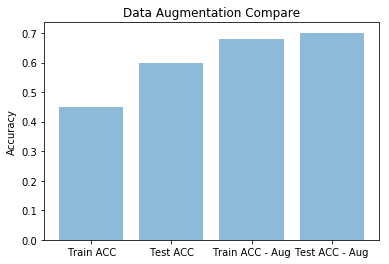

In [8]:
folds = dataset.GetFolds(FOLDS_COUNT)
augFolds = dataset.GetAugFolds(BATCH_SIZE, FOLDS_COUNT)

result = classifier.fitGenerator(BEST_EPOCHS, folds)
augResult = classifier.fitAugGenerator(BEST_EPOCHS, augFolds)

x = ['Train ACC', 'Test ACC', 'Train ACC - Aug', 'Test ACC - Aug']
y_pos = np.arange(len(x))

performance = [float("%.3f" % float(result['train_accuracy'])), 
               float("%.3f" % float(result['test_accuracy'])), 
               float("%.3f" % float(augResult['train_accuracy'])), 
               float("%.3f" % float(augResult['test_accuracy']))]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, x)
plt.ylabel('Accuracy')
plt.title('Data Augmentation Compare')
plt.show()

Podemos perceber que ao utilizar _Data Augmentation_, o modelo passa a generalizar melhor (o que faz sentido, afinal, pois ele possui uma quantidade mais vasta e variada de exemplos para poder generalizar) em comparação com o modelo que não utiliza _Data Augmentation_<br>
#### 3) Proporção entre os exemplos disponíveis
Outro experimento buscava entender a melhor proporção entre a quantidade de exemplos de cada uma das classes; O treinamento e predição da rede podem ser feito utilizando uma quantidade de exemplos de imagens categorizadas como _spam_
igual à quantidade de imagens categorizadas como não-_spam_, entretanto, é sabido que isso não reflete a distribuição no mundo real; na realidade, dentre as imagens trafegadas em aplicativos de mensageria, apenas uma pequena parcela são parte desse grupo de _spams_. Para verificar a melhor proporção, foi fixada a quantidade de épocas (após o experimento anterior) para serem experimentados, alterando a proporção de dados entre uma classe e outra.

Dataframe filled with 530 images labelled as "not_spam" and 530 images labelled "spam"
Found 678 validated image filenames belonging to 2 classes.
Found 170 validated image filenames belonging to 2 classes.
Found 212 validated image filenames belonging to 2 classes.
Found 678 validated image filenames belonging to 2 classes.
Found 170 validated image filenames belonging to 2 classes.
Found 212 validated image filenames belonging to 2 classes.
Found 678 validated image filenames belonging to 2 classes.
Found 170 validated image filenames belonging to 2 classes.
Found 212 validated image filenames belonging to 2 classes.
Found 678 validated image filenames belonging to 2 classes.
Found 170 validated image filenames belonging to 2 classes.
Found 212 validated image filenames belonging to 2 classes.
Found 678 validated image filenames belonging to 2 classes.
Found 170 validated image filenames belonging to 2 classes.
Found 212 validated image filenames belonging to 2 classes.


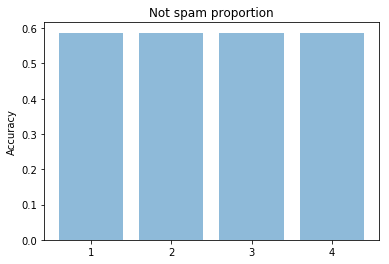

In [19]:
results = { 'proportion': [], 'test_accuracy': [] }

for proportion in NOT_SPAM_PROPORTION:
    dataset = DataSet(SPAM_FOLDER, NOT_SPAM_FOLDER, proportion)
    augFolds = dataset.GetAugFolds(BATCH_SIZE, FOLDS_COUNT)
    augResult = classifier.fitAugGenerator(BEST_EPOCHS, augFolds)
    
    results['proportion'].append(proportion)
    results['test_accuracy'].append(float("%.3f" % float(augResult['test_accuracy'])))

proportions = [e for e in results['proportion']]

y_pos = np.arange(len(proportions))
performance = [e for e in results['test_accuracy']]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, proportions)
plt.ylabel('Accuracy')
plt.title('Not spam proportion')
plt.show()

Analisando os valores do gráfico podemos chegar a conclusão de que igualar a quantidade de imagens presente em ambos os grupos é a pior decisão, confirmando o conhecimento prévio de que, na realidade, a proporção entre esses grupos não é igual à 1. Podemos perceber que a proporção de duas imagens não-_spam_ para cada imagem _spam_ é a que se saí melhor nos testes.

In [0]:
BEST_NOT_SPAM_PROPORTION = 2

#### 4) Analisando o melhor caso
Após os testes anteriores, foi feita uma verificação de como a acurácia em treino e em validação evoluem de acordo com as épocas.

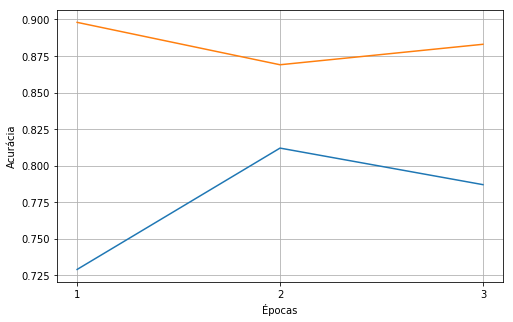

In [22]:
results = { 'epoch': [], 'train_growth_acc': [], 'test_growth_acc': [] }

dataset = DataSet(SPAM_FOLDER, NOT_SPAM_FOLDER, BEST_NOT_SPAM_PROPORTION)
augFolds = dataset.GetAugFolds(BATCH_SIZE, FOLDS_COUNT)
augResult = classifier.fitAugGenerator(BEST_EPOCHS, augFolds)

for i in range(1, 4):
    results['epoch'].append(i)
    results['test_growth_acc'].append(float("%.3f" % float(augResult['test_growth_acc'][(i-1)])))
    results['train_growth_acc'].append(float("%.3f" % float(augResult['train_growth_acc'][(i-1)])))

epochs = [e for e in results['epoch']]

gs = gridspec.GridSpec(1, 1, figure=plt.figure(num=None, figsize=(8, 5)))
ax = plt.subplot(gs[0])
ax.grid(True)
ax.set_xlabel('Épocas')
ax.set_ylabel('Acurácia')
ax.set_xticks([i for i in range(0,len(epochs))])
ax.set_xticklabels(epochs)
ax.plot(np.array([k for k in results['test_growth_acc']]), label="Test ACC")
ax.plot(np.array([k for k in results['train_growth_acc']]), label="Train ACC")
ax.legend()

### Conclusões
Após os experimentos podemos concluir que um número pequeno de épocas naturalmente não é satisfatório, enquanto números maiores que 40 já não conseguem justificar o tempo a mais de treinamento; é possível afirmar que para esse modelo, 40 épocas é um valor satisfatório.<br><br>
Ao mesmo tempo, podemos chegar à conclusão de que a proporção entre exemplos categorizados como _spam_ e exemplos categorizados como não-_spam_ são é também um fator importante para a classificação; uma quantidade igual de exemplos de ambas as classes não condiz com a realidade, e por isso não possui uma acurácia tão boa quanto por exemplo, casos onde a quantidade de imagens categorizadas como não-_spam_ correspondem ao dobro, triplo ou quádruplo da quantidade de imagens categorizadas como _spam_. 
<br>
Nos experimentos realizados, a proporção de duas imagens categorizadas como não-_spam_ para cada imagem categorizada como _spam_ é o melhor caso. <br><br>
Também pudemos perceber o ganho real ao utilizar _Data Augmentation_ para este tipo de aplicação, sendo possível obter boas taxas de acurácia mesmo tendo uma quantidade limitada de exemplos disponíveis.